# 周波数ドメイン

In [6]:
!wget https://github.com/eiichiromomma/CVMLAB/raw/master/img/sample.jpg
!pip install japanize-matplotlib

--2021-06-05 12:18:23--  https://github.com/eiichiromomma/CVMLAB/raw/master/img/sample.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/sample.jpg [following]
--2021-06-05 12:18:24--  https://raw.githubusercontent.com/eiichiromomma/CVMLAB/master/img/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78522 (77K) [image/jpeg]
Saving to: ‘sample.jpg.1’

sample.jpg.1        100%[===================>]  76.68K  --.-KB/s    in 0.009s  

2021-06-05 12:18:24 (8.67 MB/s) - ‘sample.jpg.1’ saved [78522/78522]




## Pythonでの2次元フーリエ変換
numpy使うのが手っ取り早い。OpenCVの方はCインターフェイス時代からの影響で最適サイズを拾ったり，出力が実部虚部くっついてたり，2chだったり(オプション)と面倒。あとnumpyはMATLABでおなじみfftshiftが使える。

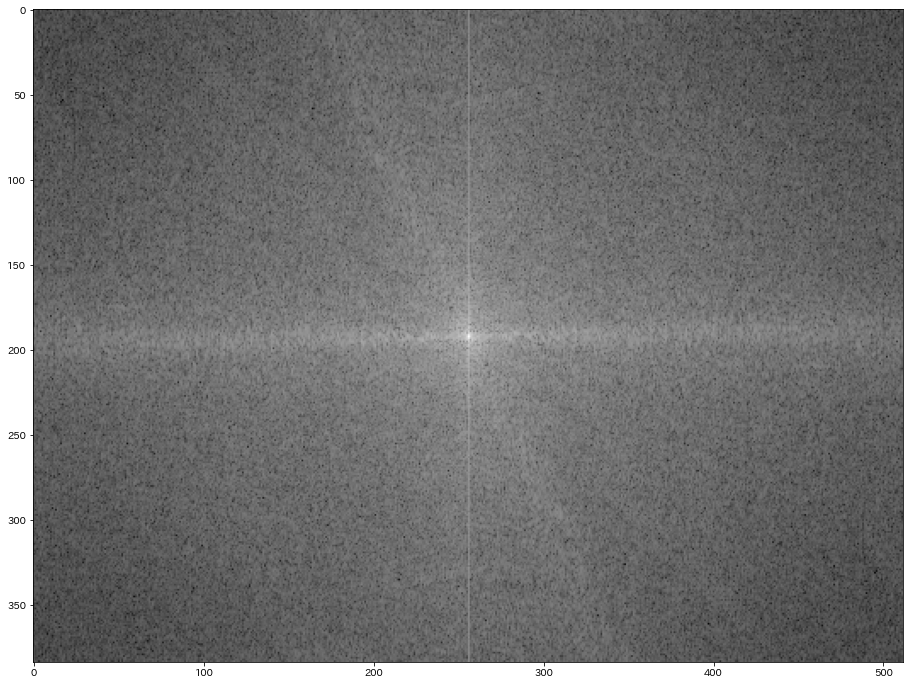

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import japanize_matplotlib
# plt.rc('xtick', bottom=False, labelbottom=False)
# plt.rc('ytick', left = False, labelleft = False)
plt.rc('figure', figsize=[24,12])
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
fimg = np.fft.fft2(gimg)
fimg = np.fft.fftshift(fimg)
plt.imshow(np.log(abs(fimg)+1), cmap='gray')

ifft2で元に戻す前にfftshiftで四隅を低周波に戻す。ifft2の返り値は複素数なので実部だけnp.realで表示させる。

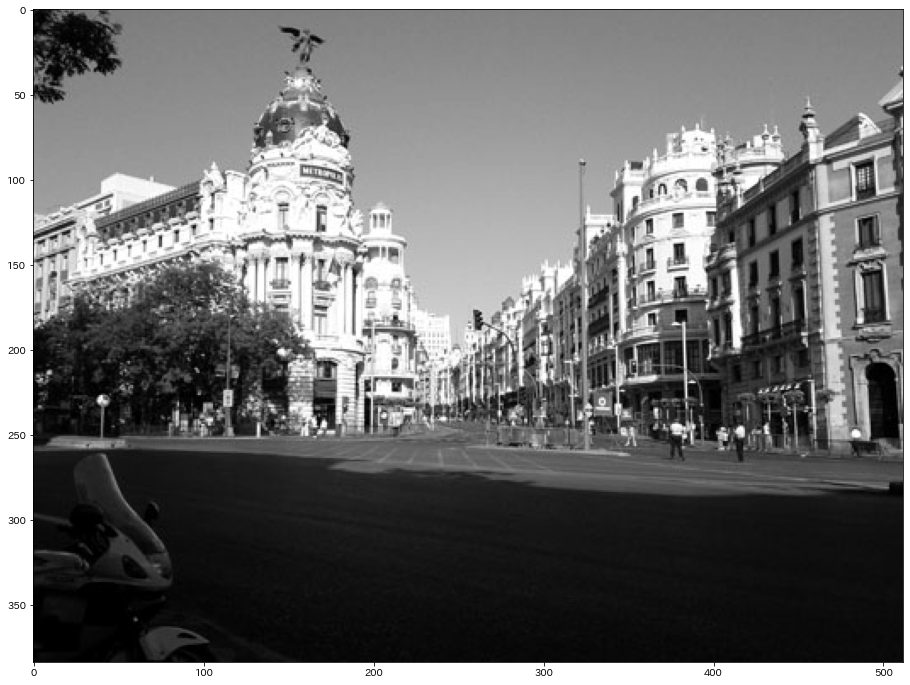

In [8]:
iimg = np.fft.ifft2(np.fft.fftshift(fimg))
plt.imshow(np.real(iimg), cmap='gray')

### ちなみに
実部の振幅スペクトルだけ使って逆フーリエ変換すると，やや悪夢っぽい画像が出てくる

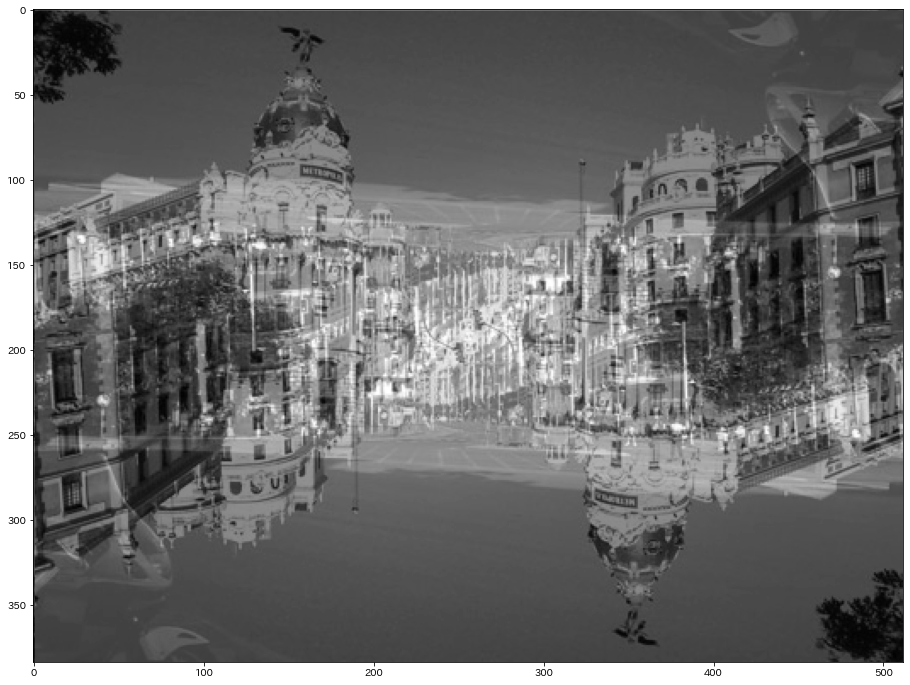

In [9]:
iimg = np.fft.ifft2(np.fft.fftshift(np.real(fimg)))
plt.imshow(np.real(iimg), cmap='gray')

## OpenCVでfftshift
OpenCVの場合fftshiftが無くて面倒なので市松模様の画像を要素ごとに乗算して高周波と低周波を反転させる技を使う。cv2.DFT_COMPLEX_OUTPUTで2チャンネルで実部虚部に出してくれる。 縦横比1:1で一辺が2のべき乗であった方が楽なので512x512で処理する。

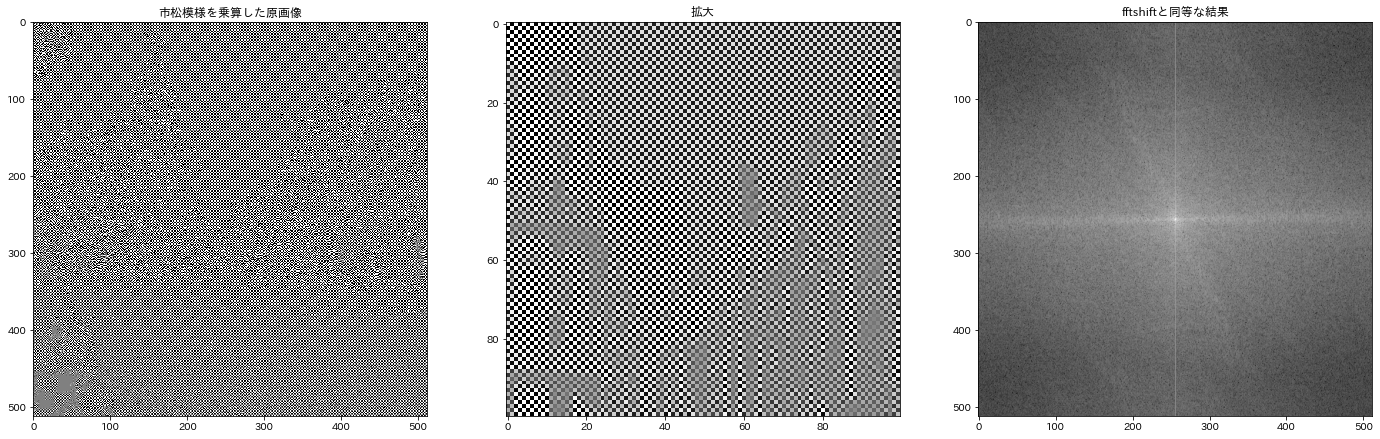

In [10]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
gimg = cv2.resize(gimg, (512,512))
emat = np.eye(2)
emat[emat==0] = -1
gimg.shape
emask = np.tile(emat, (256, 256)) 
mimg = gimg*emask
plt.subplot(1,3,1)
plt.imshow(mimg, cmap='gray', vmin=-1, vmax=1)
plt.title('市松模様を乗算した原画像')
plt.subplot(1,3,2)
plt.imshow(mimg[200:300, 200:300], cmap='gray')
plt.title('拡大') 
fimg = cv2.dft(mimg, flags=cv2.DFT_COMPLEX_OUTPUT)
cimg = fimg[:, :, 0] + 1j * fimg[:, :, 1] #面倒なので複素数に戻す
plt.subplot(1,3,3)
plt.imshow(np.log(abs(cimg)+1), cmap='gray')
plt.title('fftshiftと同等な結果');

dftでflags=cv2.DFT_COMPLEX_INPUT+cv2.DFT_INVERSEとして2ch入力かつ逆フーリエであることを指定する。結果をそのまま表示すると(-1)^(x+y)のままなので，再度(-1)^(x+y)の乗算をして戻す

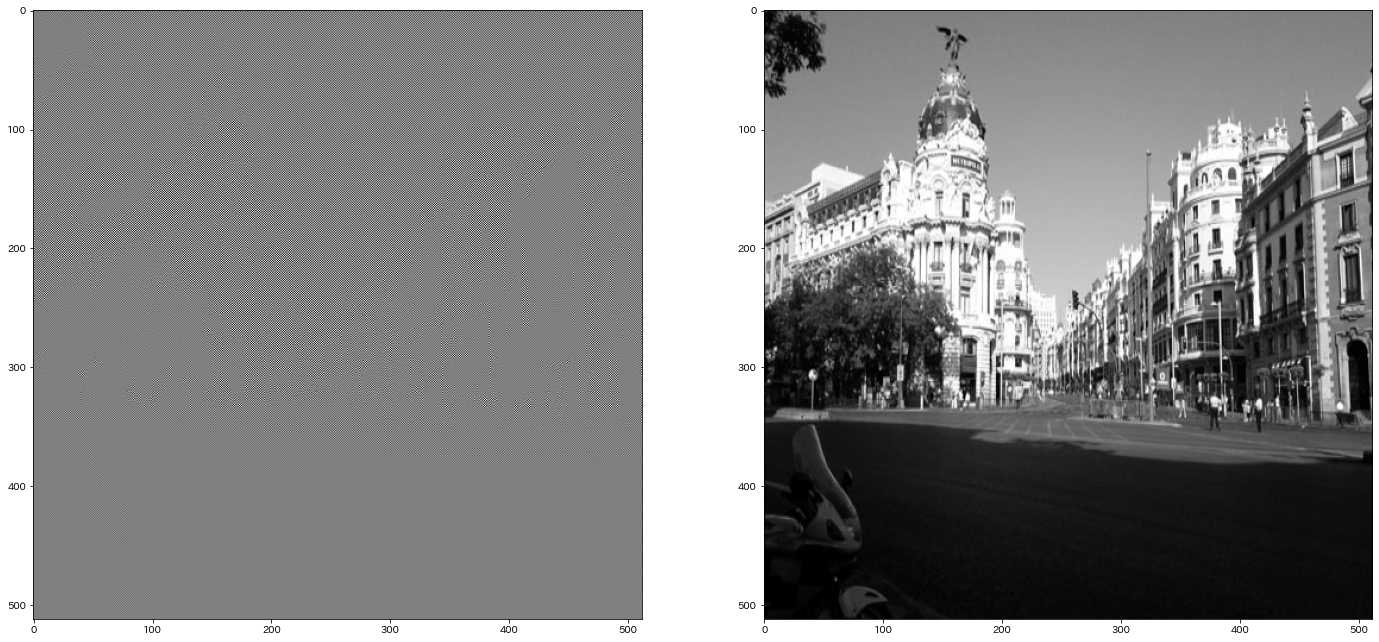

In [11]:
iimg = cv2.dft(fimg, flags=cv2.DFT_COMPLEX_INPUT+cv2.DFT_INVERSE)
plt.subplot(1,2,1)
plt.imshow(iimg[:, :, 0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(iimg[:, :, 0]*emask, cmap='gray')

## 窓関数
ここではscipyのHamming窓を使う

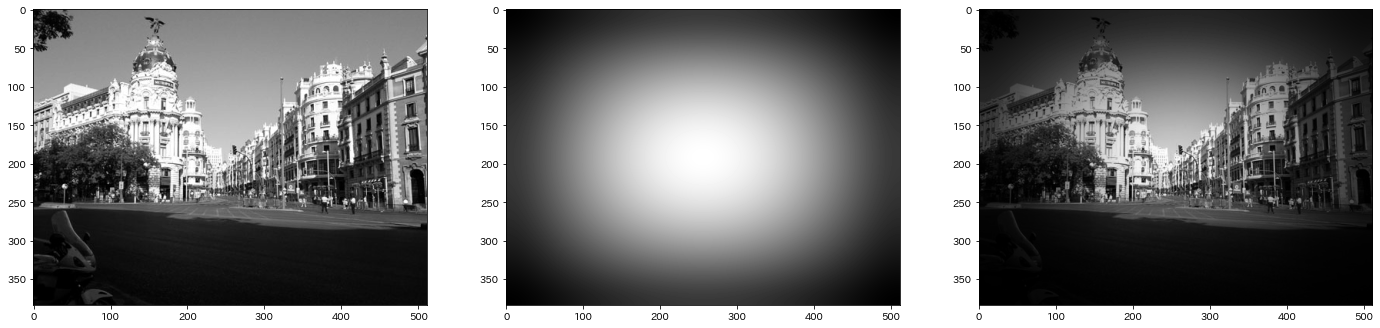

In [12]:
from scipy.signal import hamming
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
hr = hamming(gimg.shape[0])
hc = hamming(gimg.shape[1])
ham2d = np.sqrt(np.outer(hr, hc))
hamimg = np.multiply(gimg, ham2d)

plt.subplot(1,3,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(ham2d, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(hamimg, cmap='gray')



窓関数を使わない場合，左下のように道路の影と空が境界となり垂直方向への高周波が生じていることがわかる。
一方窓関数を使うと左下に生じていた高周波が消えているのが分かるが，原画像の中央部以外の高周波成分も減衰しているのも分かる。

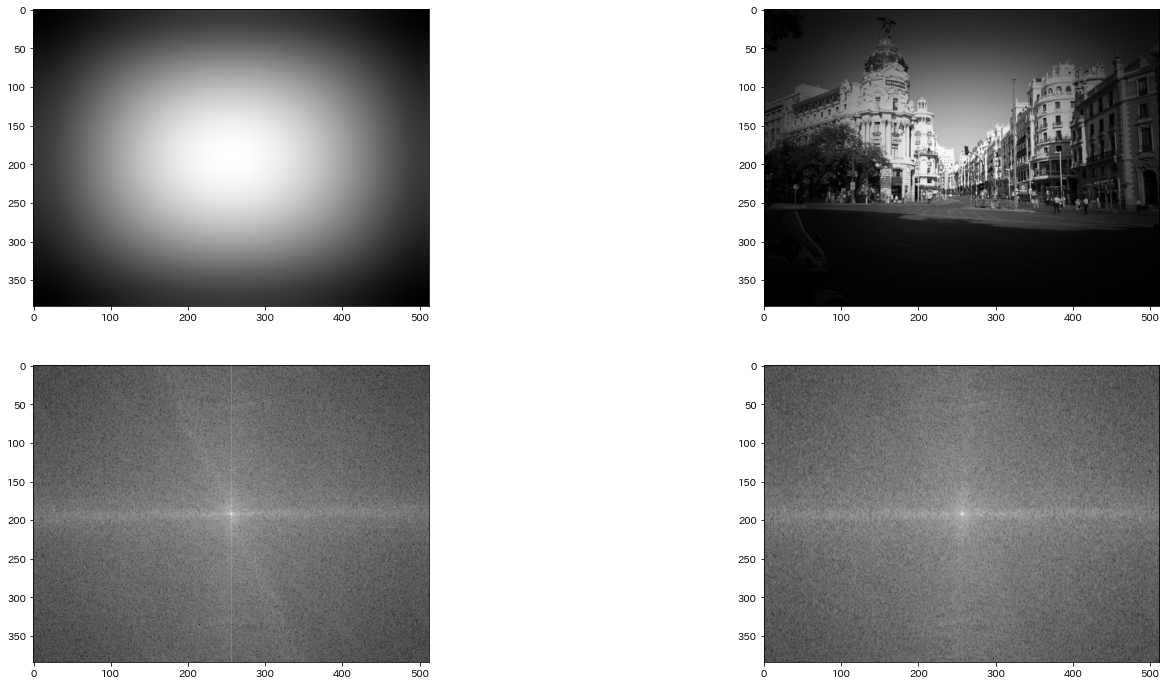

In [13]:
plt.subplot(2,2,1)
plt.imshow(ham2d, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(hamimg, cmap='gray')

fimg = np.fft.fft2(gimg)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,2,3)
plt.imshow(np.log(abs(fimg)+1), cmap='gray')

hfimg = np.fft.fft2(hamimg)
hfimg = np.fft.fftshift(hfimg)
plt.subplot(2,2,4)
plt.imshow(np.log(abs(hfimg)+1), cmap='gray')

先程と同様にfftshiftしたパワースペクトルをifftしてもとに戻す。

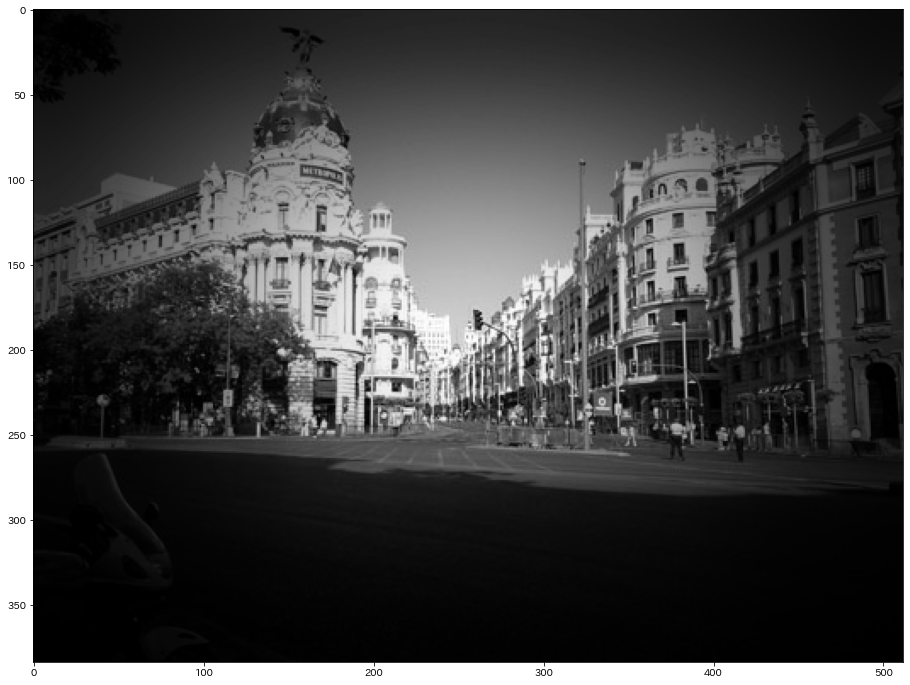

In [14]:
ihfimg = np.fft.ifft2(np.fft.fftshift(hfimg))
plt.imshow(np.real(ihfimg), cmap='gray')


### パディングする方法
画像の上下左右が連結していないことは明示的になるが，信号の不連続性による高周波の発生に対しては効果があるとは思えない。出力されるパワースペクトルはパディングしたぶん大きくなるので，空間周波数の分解能は上がる。

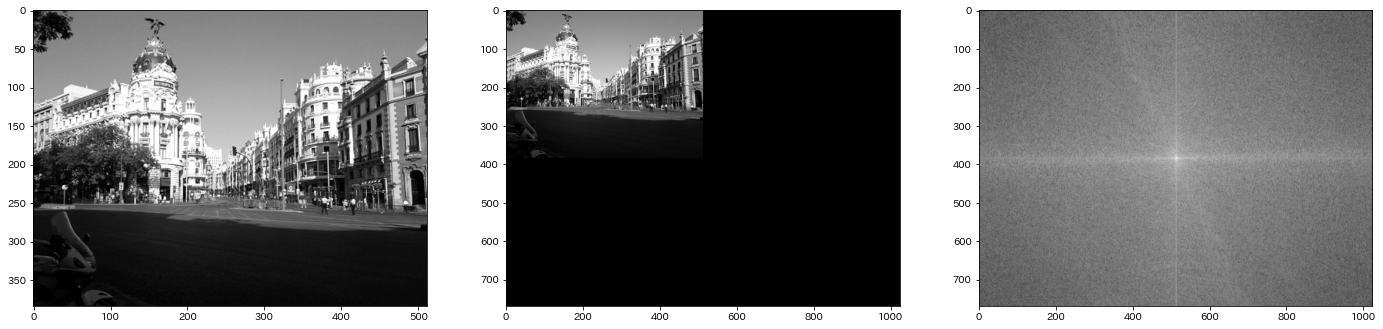

In [15]:
M, N = gimg.shape
P = M*2
Q = N*2
pimg = np.zeros((P, Q), np.uint8)
pimg[0:M, 0:N] = gimg
# pimg[192: 192+M, 256:256+N] = gimg
plt.subplot(1,3,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(pimg, cmap='gray')
pfimg = np.fft.fft2(pimg)
pfimg = np.fft.fftshift(pfimg)
plt.subplot(1,3,3)
plt.imshow(np.log(abs(pfimg)+1), cmap='gray')


## freqz2の代わり
MATLABにはfreqz2で空間フィルタの周波数応答を見る関数が用意されているが，Pythonには存在しない。スケールが合っていて，結果の周波数分解能が原画像と同じであれば良いので，
1. 原画像と同サイズのzerosを用意
2. 1.の行列の左上にフィルタを置く(前述のパディングする方法と同じ意味)
3. 2.の行列をfft2で応答が得られる(可視化の際にはfftshift)


[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]


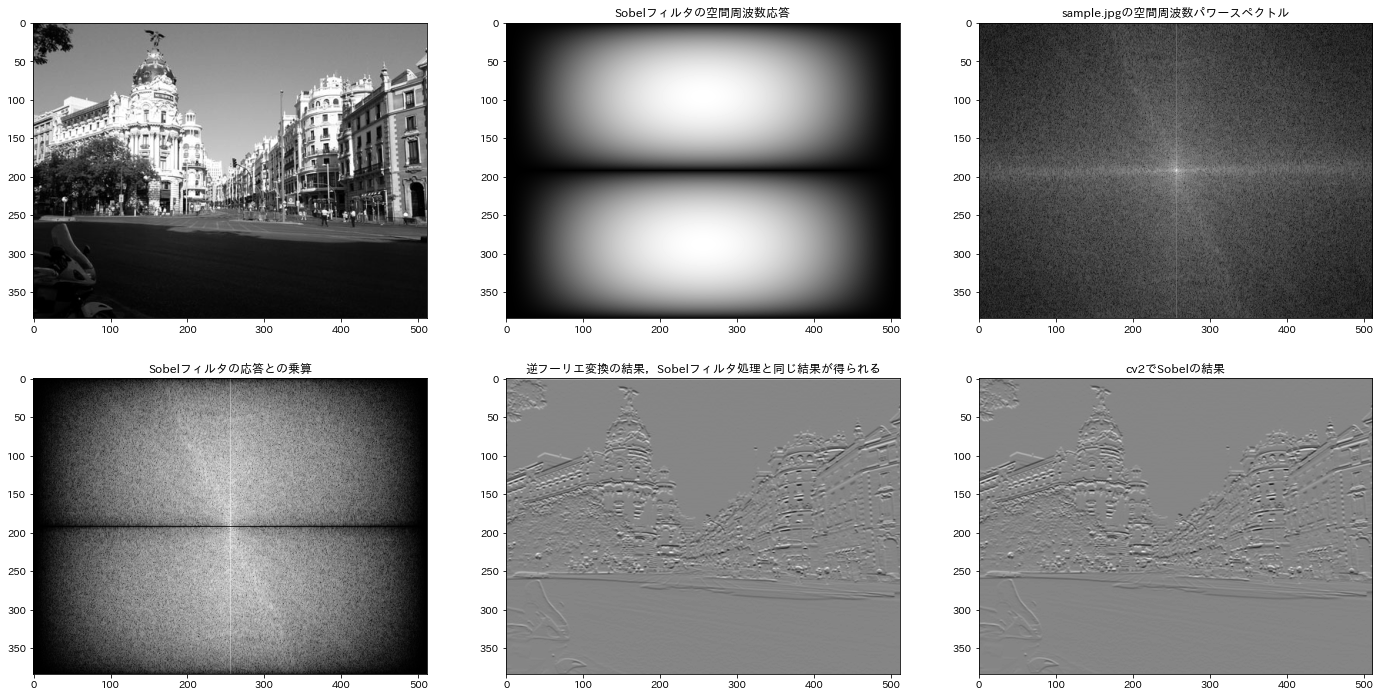

In [16]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
k = np.array([[1, 2, 1],[0, 0, 0],[-1,-2,-1]], dtype=np.float)
print(k)
# 原画像と同じサイズの0行列を用意し，カーネルを1つだけ上書きする(3x3)
zimg = np.zeros(gimg.shape, dtype=np.float)
zimg[0:k.shape[0], 0:k.shape[1]] = k
fz = np.fft.fft2(zimg)
fz = np.fft.fftshift(fz)
plt.subplot(2,3,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(fz)+1), cmap='gray')
plt.title('Sobelフィルタの空間周波数応答')
fimg = np.fft.fft2(gimg/255.)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,3,3)
plt.imshow(np.log(np.abs(fimg)+1), cmap='gray')
plt.title('sample.jpgの空間周波数パワースペクトル')
fdst = np.multiply(fimg, fz)
plt.subplot(2,3,4)
plt.imshow(np.log(np.abs(fdst)+1), cmap='gray')
plt.title('Sobelフィルタの応答との乗算')
fdst = np.fft.fftshift(fdst)
ifdst = np.fft.ifft2(fdst)
plt.subplot(2,3,5)
plt.imshow(np.real(ifdst), cmap='gray')
plt.title('逆フーリエ変換の結果，Sobelフィルタ処理と同じ結果が得られる');
plt.subplot(2,3,6)
plt.imshow(cv2.Sobel(gimg/255., -1, dx=0, dy=1, ksize=3), cmap='gray')
#plt.imshow(cv2.filter2D(gimg/255., -1, k), cmap='gray') #勾配が反転するが特に問題ない
plt.title('cv2でSobelの結果');

### Sobelフィルタの空間周波数応答のSurface表示
縦方向の抽出というよりは，水平方向の遮断と見た方が理解し易い。

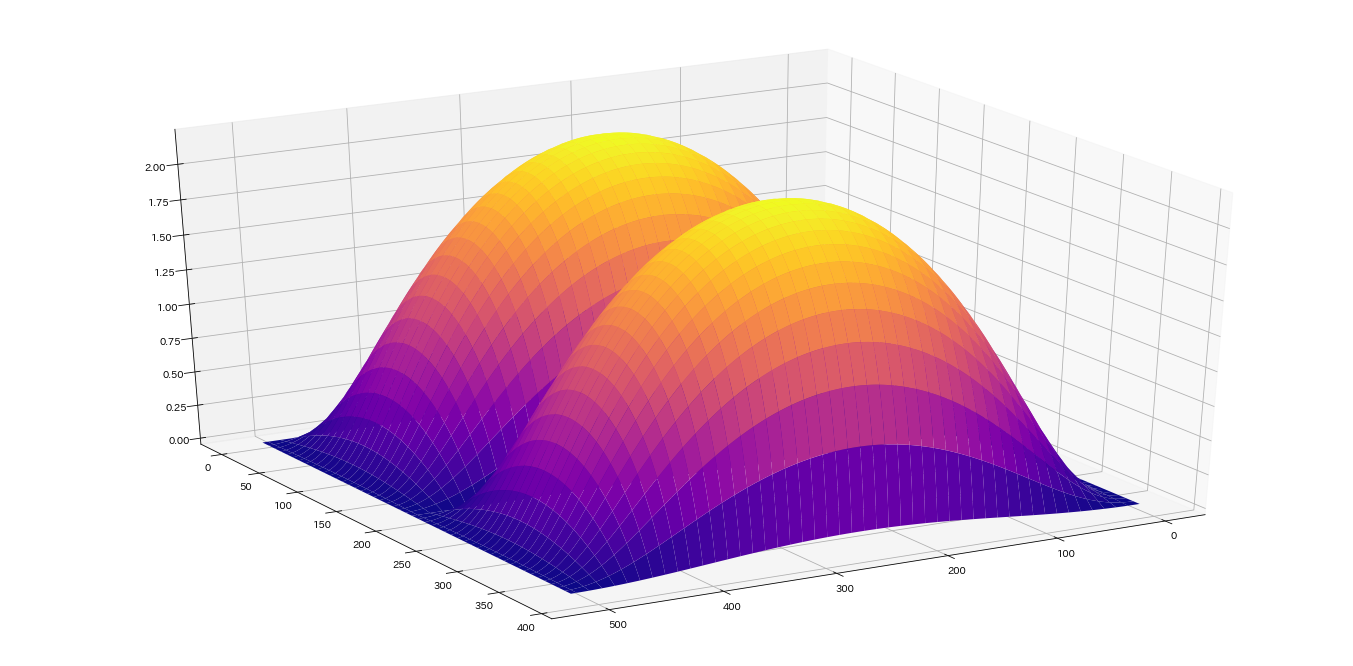

In [17]:
from mpl_toolkits.mplot3d import axes3d
plt.rc('xtick', bottom=True, labelbottom=True)
plt.rc('ytick', left = True, labelleft = True)
afz = np.log(np.abs(fz)+1)
x = np.linspace(0, afz.shape[1], num=afz.shape[1])
y = np.linspace(0, afz.shape[0], num=afz.shape[0])
X, Y = np.meshgrid(x,y)
ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=30, azim=60)
ax3d.plot_surface(X, Y, afz, cmap='plasma')

## Laplacianフィルタの空間周波数応答
Sobelと同様に空間周波数応答を見る。
8近傍Laplacianなので低周波(中央)以外はほぼ通過するHPFになっている。

[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]


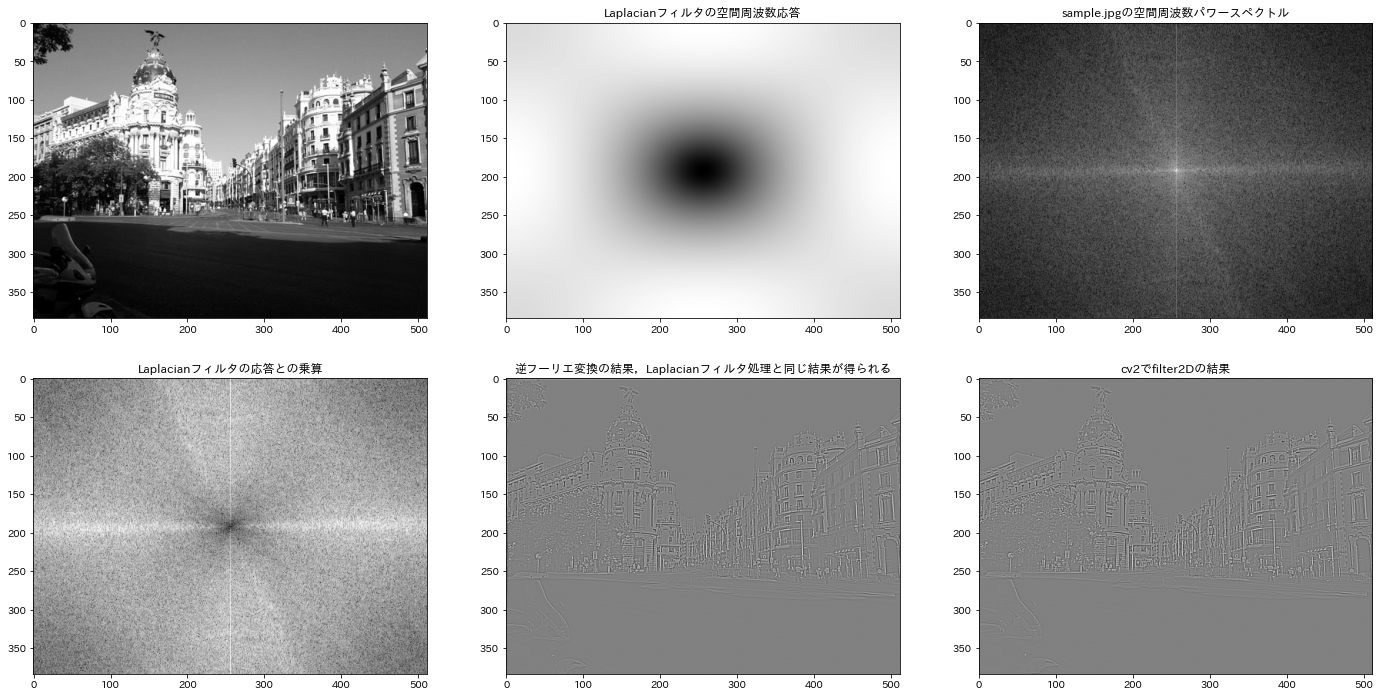

In [18]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
k = np.array([[-1, -1, -1],[-1, 8, -1],[-1,-1,-1]], dtype=np.float)
print(k)
# 原画像と同じサイズの0行列を用意し，カーネルを1つだけ上書きする(3x3)
zimg = np.zeros(gimg.shape, dtype=np.float)
zimg[0:k.shape[0], 0:k.shape[1]] = k
fz = np.fft.fft2(zimg)
fz = np.fft.fftshift(fz)
plt.subplot(2,3,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(fz)+1), cmap='gray')
plt.title('Laplacianフィルタの空間周波数応答')
fimg = np.fft.fft2(gimg/255.)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,3,3)
plt.imshow(np.log(np.abs(fimg)+1), cmap='gray')
plt.title('sample.jpgの空間周波数パワースペクトル')
fdst = np.multiply(fimg, fz)
plt.subplot(2,3,4)
plt.imshow(np.log(np.abs(fdst)+1), cmap='gray')
plt.title('Laplacianフィルタの応答との乗算')
fdst = np.fft.fftshift(fdst)
ifdst = np.fft.ifft2(fdst)
plt.subplot(2,3,5)
plt.imshow(np.real(ifdst), cmap='gray')
plt.title('逆フーリエ変換の結果，Laplacianフィルタ処理と同じ結果が得られる');
plt.subplot(2,3,6)
plt.imshow(cv2.filter2D(gimg/255., -1, k), cmap='gray')
plt.title('cv2でfilter2Dの結果');

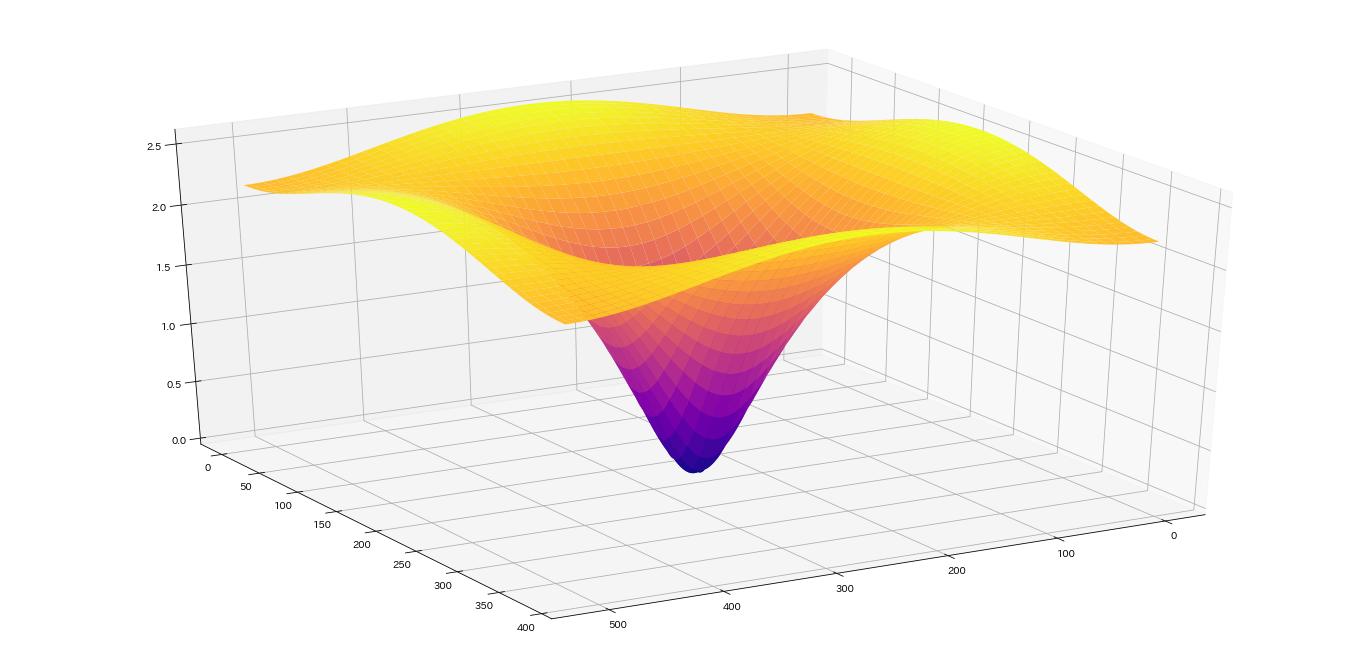

In [19]:
from mpl_toolkits.mplot3d import axes3d
plt.rc('xtick', bottom=True, labelbottom=True)
plt.rc('ytick', left = True, labelleft = True)
afz = np.log(np.abs(fz)+1)
x = np.linspace(0, afz.shape[1], num=afz.shape[1])
y = np.linspace(0, afz.shape[0], num=afz.shape[0])
X, Y = np.meshgrid(x,y)
ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=30, azim=60)
ax3d.plot_surface(X, Y, afz, cmap='plasma')

## 平均化フィルタの空間周波数応答
詳細は次回扱うがLPFになっているのが分かる

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


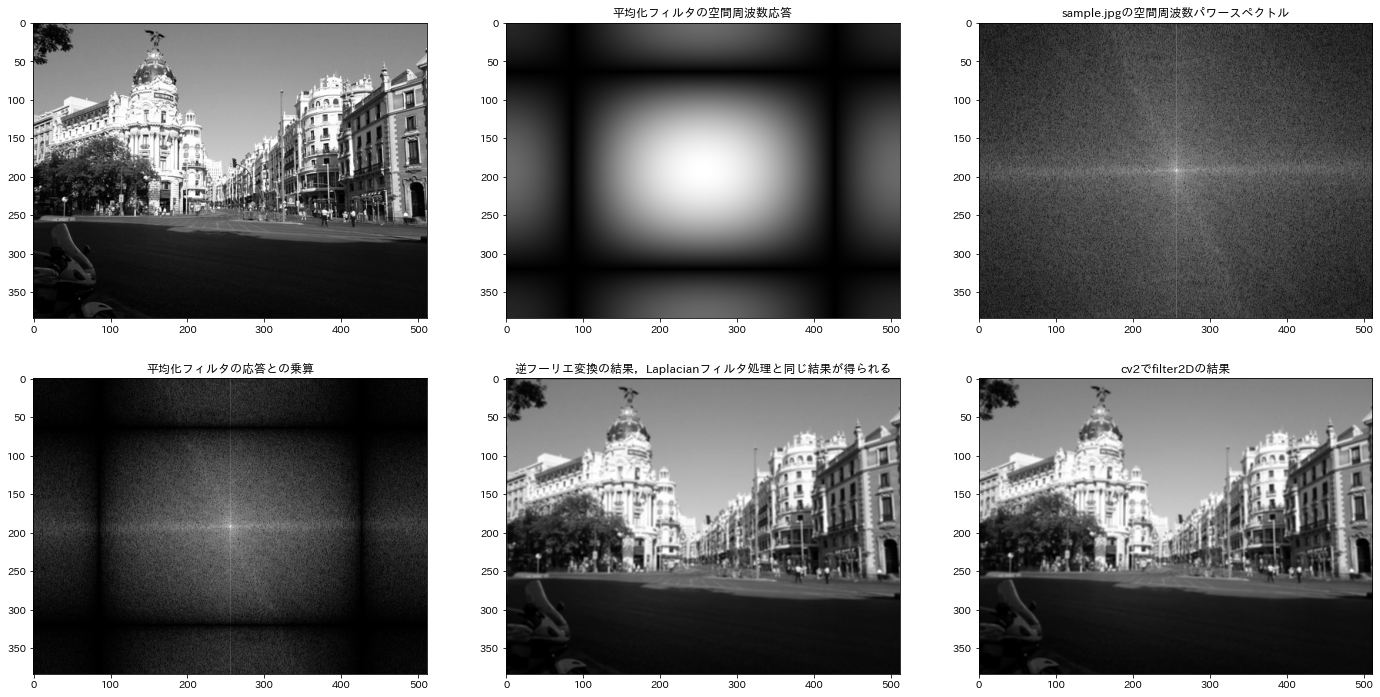

In [20]:
gimg = cv2.imread('sample.jpg', cv2.IMREAD_GRAYSCALE)
k = np.array([[1/9., 1/9., 1/9.],[1/9., 1/9., 1/9.],[1/9.,1/9.,1/9.]], dtype=np.float)
print(k)
# 原画像と同じサイズの0行列を用意し，カーネルを1つだけ上書きする(3x3)
zimg = np.zeros(gimg.shape, dtype=np.float)
zimg[0:k.shape[0], 0:k.shape[1]] = k
fz = np.fft.fft2(zimg)
fz = np.fft.fftshift(fz)
plt.subplot(2,3,1)
plt.imshow(gimg, cmap='gray')
plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(fz)+1), cmap='gray')
plt.title('平均化フィルタの空間周波数応答')
fimg = np.fft.fft2(gimg/255.)
fimg = np.fft.fftshift(fimg)
plt.subplot(2,3,3)
plt.imshow(np.log(np.abs(fimg)+1), cmap='gray')
plt.title('sample.jpgの空間周波数パワースペクトル')
fdst = np.multiply(fimg, fz)
plt.subplot(2,3,4)
plt.imshow(np.log(np.abs(fdst)+1), cmap='gray')
plt.title('平均化フィルタの応答との乗算')
fdst = np.fft.fftshift(fdst)
ifdst = np.fft.ifft2(fdst)
plt.subplot(2,3,5)
plt.imshow(np.real(ifdst), cmap='gray')
plt.title('逆フーリエ変換の結果，Laplacianフィルタ処理と同じ結果が得られる');
plt.subplot(2,3,6)
plt.imshow(cv2.filter2D(gimg/255., -1, k), cmap='gray')
plt.title('cv2でfilter2Dの結果');

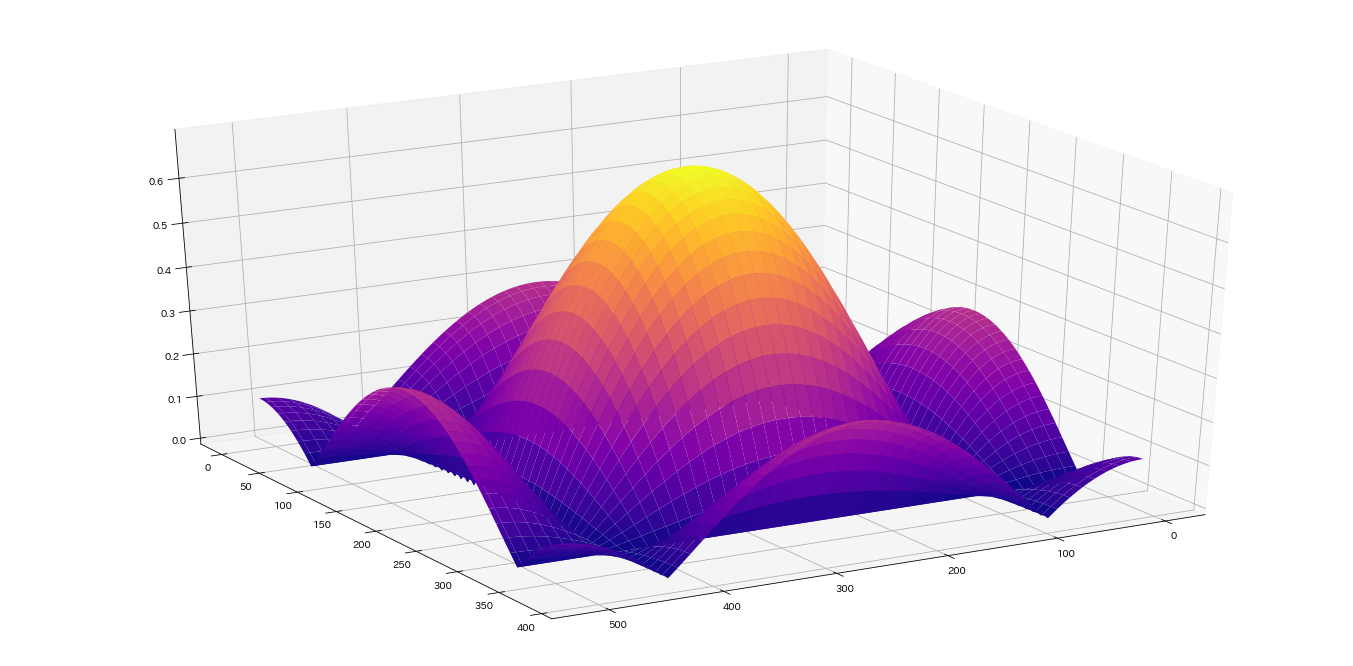

In [21]:
from mpl_toolkits.mplot3d import axes3d
plt.rc('xtick', bottom=True, labelbottom=True)
plt.rc('ytick', left = True, labelleft = True)
afz = np.log(np.abs(fz)+1)
x = np.linspace(0, afz.shape[1], num=afz.shape[1])
y = np.linspace(0, afz.shape[0], num=afz.shape[0])
X, Y = np.meshgrid(x,y)
ax3d = plt.axes(projection = '3d')
ax3d.view_init(elev=30, azim=60)
ax3d.plot_surface(X, Y, afz, cmap='plasma')